# <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Introduction](#intro)
2. [Defining imports](#imports)
3. [Exploring the data](#explore)
4. [Defining pre-processing / utilities](#utilis)
5. [Defining model](#models)
6. [Training the model(s)](#m)
7. [Plot evaluations](#background)
8. [Viewing output](#alerts)
9. [Creating final submission](#tf_lite)
10. [Future work](#future_work)
11. [References](#references)

# <font color='289C4E'>1. Introduction <font><a class='anchor' id='intro'></a> [↑](#top)
    
    
The following notebook will define a base neural network model with Tensorflow to classify ASL gestures, and continutelly tweak the model to see how we can improve overall validation accuracy. 

# <font color='289C4E'>2. Defining imports <font><a class='anchor' id='imports'></a> [↑](#top)

In [1]:
import os
import json
import gc
import pickle
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
# import zipfile
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import multiprocessing as mp
from tqdm import tqdm
import imgaug.augmenters as iaa
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, optimizers
import tensorflow.keras.models as models

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Conv3D, BatchNormalization, Activation, MaxPooling3D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Reshape

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers
pd.options.display.max_rows = 9999

something I found really helpful during this process is utlizing a GPU! It's available for use if you click the 3 dots in the top right and click "accelerator"

I was not familar with how to use one prior nor did I realize it was available - the following code just checks if you are using a GPU or not

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# <font color='289C4E'>3. Exploring the data <font><a class='anchor' id='explore'></a> [↑](#top)

In [3]:
# file paths for given input files 
TRAIN = "/kaggle/input/asl-signs/train.csv"
DATA_PATH = '../input/asl-signs/'
MAPPINGS = "../input/asl-signs/sign_to_prediction_index_map.json"
AGGREGATED_DATA_PATH = '../input/isolated-sign-language-aggregation-dataset/'

### <font color='289C4E'> 3.1. Example of data landmark <font><a class='anchor' id='explore'></a>

This is just taken from the competition guidelines, but putting it here for easy reference

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- Landmark data (ex face, right hand etc) is stored under `train_landmark_files` directory with the following naming convention: 
`train_landmark_files/[participant_id]/[sequence_id].parquet`
- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model
for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

In [4]:
sample_data = pd.read_parquet("/kaggle/input/asl-signs/train_landmark_files/36257/3762317508.parquet")
sample_data.describe()
sample_data.head(10)

,frame,row_id,type,landmark_index,x,y,z
0,0,0-face-0,face,0,0.536712,0.421679,-0.054983
1,0,0-face-1,face,1,0.532607,0.388884,-0.064112
2,0,0-face-2,face,2,0.535190,0.405216,-0.043147
3,0,0-face-3,face,3,0.515270,0.369050,-0.034260
4,0,0-face-4,face,4,0.530208,0.380113,-0.063684
5,0,0-face-5,face,5,0.527388,0.371860,-0.053191
6,0,0-face-6,face,6,0.521091,0.354423,-0.005393
7,0,0-face-7,face,7,0.438529,0.376151,0.035212
8,0,0-face-8,face,8,0.515626,0.336895,0.014367
9,0,0-face-9,face,9,0.512473,0.325666,0.020026


### <font color='289C4E'> 3.2. Example of training data <font><a class='anchor' id='explore'></a>

Again, this is just taken from the competition guidelines, but putting it here for easy reference


- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

In [5]:
train_data = pd.read_csv(TRAIN)
print('train shape', train_data.shape)
train_data.head()

train shape (94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


### <font color='289C4E'> 3.3. Distribution of signs <font><a class='anchor' id='explore'></a>

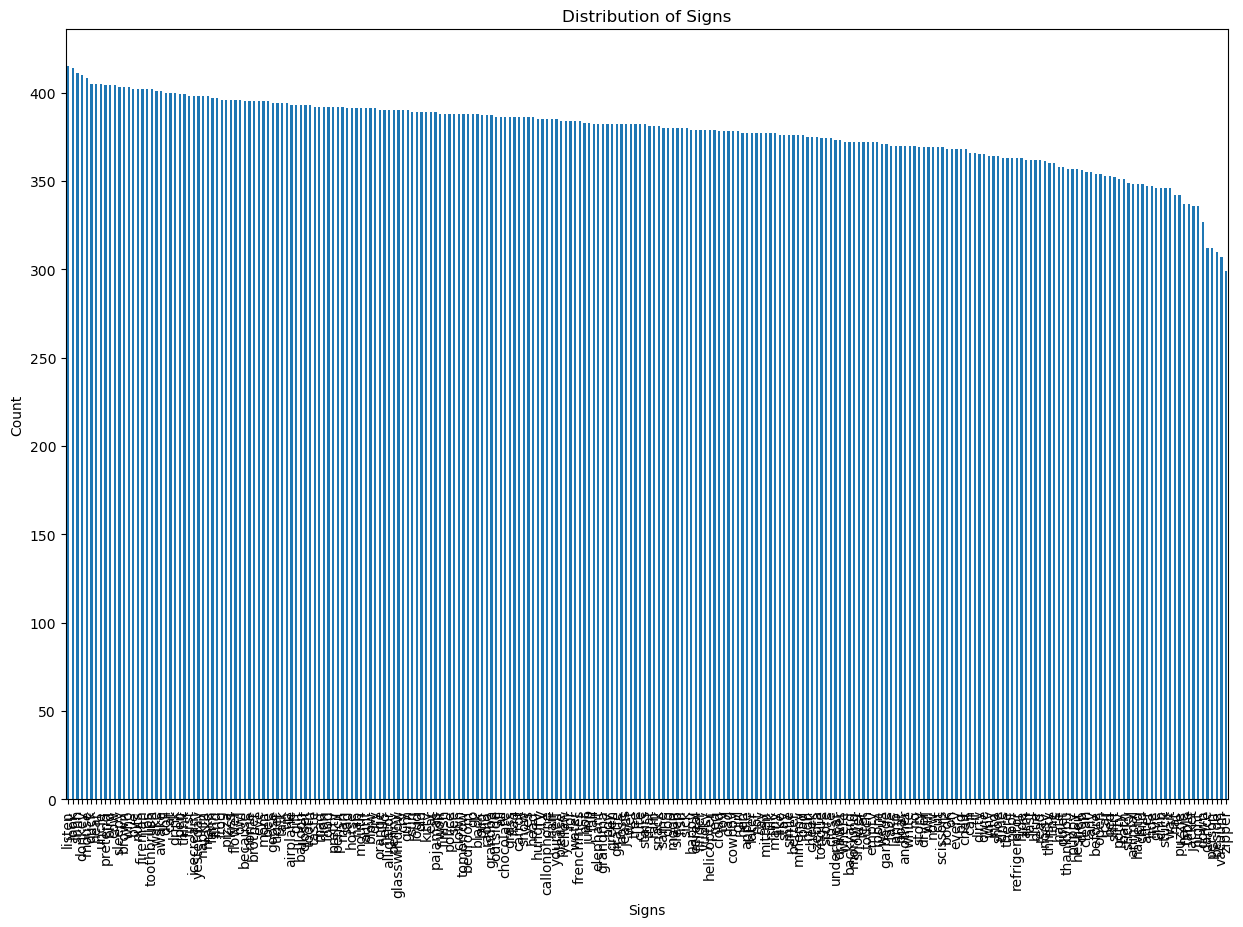

In [6]:
# Count the number of occurrences of each sign
counts = train_data['sign'].value_counts()

# Plot a bar graph
fig, ax = plt.subplots(figsize=(15, 10))
train_data['sign'].value_counts().plot(kind='bar', ax=ax)

# Set title and labels
ax.set_title('Distribution of Signs')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')

# Show the plot
plt.show()

### <font color='289C4E'> 3.3. Example of sign prediction index map <font><a class='anchor' id='explore'></a>


In [7]:
sign_prediction_index_map = pd.read_json(MAPPINGS, lines=True, orient='columns')
sign_prediction_index_map.head()

,TV,after,airplane,all,alligator,animal,another,any,apple,arm,...,why,will,wolf,yellow,yes,yesterday,yourself,yucky,zebra,zipper
0,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249


### <font color='289C4E'> 3.4. Sign column examination <font><a class='anchor' id='explore'></a>
    
- 94477 rows of data
- 250 unique signs
- "listen" is the most frequent sign
- "415" is the max number of samples for one sign

In [8]:
display(train_data["sign"].describe().to_frame().T)

,count,unique,top,freq
sign,94477,250,listen,415


### <font color='289C4E'> 3.5. Participant column examination <font><a class='anchor' id='explore'></a>
    
- 94477 rows of data
- 21 unique participants

In [9]:
display(train_data["participant_id"].astype(str).describe().to_frame().T)

,count,unique,top,freq
participant_id,94477,21,49445,4968


# <font color='289C4E'>4. Define Utilties/Preprocessing class <font><a class='anchor' id='utilis'></a> [↑](#top)
    
    
Currently, this notebook is referencing an aggregated dataset!
    
For future work, I would like to pre-process the data here and potentially look into data augmentation to create more data! I'm mainly using this notebook to test what type of model modifications improve classification accuracy

In [10]:
class Utilties:
    def __init__(self):
        self.aggregation_data_path = AGGREGATED_DATA_PATH
        self.data_path = DATA_PATH
        self.is_training = True
        self.num_classes = 250
        self.rows_per_frame = 543 
        
    def load_relevant_data_subset_with_imputation(self, pq_path):
        data_columns = ['x', 'y', 'z']
        data = pd.read_parquet(pq_path, columns=data_columns)
        data.replace(np.nan, 0, inplace=True)
        n_frames = int(len(data) / self.rows_per_frame)
        data = data.values.reshape(n_frames, self.rows_per_frame, len(data_columns))
        return data.astype(np.float32)

    def load_relevant_data_subset(self, pq_path):
        data_columns = ['x', 'y', 'z']
        data = pd.read_parquet('/kaggle/input/asl-signs/' + pq_path, columns=data_columns)
        n_frames = int(len(data) / self.rows_per_frame)
        data = data.values.reshape(n_frames, self.rows_per_frame, len(data_columns))
        return data.astype(np.float32)

    def read_dict(self, file_path):
        path = os.path.expanduser(file_path)
        with open(path, "r") as f:
            dic = json.load(f)
        return dic
    
    def load_data(self):
        train = pd.read_csv(f"{self.aggregation_data_path}train.csv")
        label_index = self.read_dict(f"{self.data_path}sign_to_prediction_index_map.json")
        index_label = dict([(label_index[key], key) for key in label_index])
        train["label"] = train["sign"].map(lambda sign: label_index[sign])
        return train
        

# <font color='289C4E'>5. Define Model(s) <font><a class='anchor' id='models'></a> [↑](#top)
    
The following class contains 10 different model architectures that we will train and test. each model is a small variation/adjustment of the previous model
   
The main motiviation for this is I wanted to test out differing hyperparameters, arhceituceres and layers but wanted to keep the orignial models for comparision to track if the changes I am making are improving or decreasing classification

In [11]:
class Model:
    def __init__(self, is_training):
        self.utilties = Utilties()
        self.train_df = self.utilties.load_data()
        self.model = None
        self.epochs = None
        self.is_training = is_training
        
    def find_pre_processed(self):
        try:
            x_ = np.load('/kaggle/working/preprocessed_x.npy')
            y_ = np.load('/kaggle/working/preprocessed_y.npy')
            print("found preprocessed_x.npy")
            print('found preprocessed_y.npy')
        except Exception as e: 
            print("prepocessed files not found", e)
            x_ = np.array([])
            y_ = np.array([])
        return x_,y_
        
    '''
    load preprocessed sets
    this gave us valiation accuracy of ~60% and accuarcy of %70
    '''
    def preprocess(self):
        if self.is_training:
            ## atempt to fetch saved version if available
            X,y = self.find_pre_processed()
            if X.size == 0 and y.size == 0:
                xs = []
                ys = []
                num_frames = np.zeros(len(self.train_df))
                for i in tqdm(range(len(self.train_df))):
                    path = f"{DATA_PATH}{self.train_df.iloc[i].path}"
                    if i % 500 == 0:
                        print('preprocessing ith datafile: ', i)
                    data = self.utilties.load_relevant_data_subset_with_imputation(path)
                    ## Mean Aggregation
                    xs.append(np.mean(data, axis=0))
                    ys.append(self.train_df.iloc[i].label)
                    num_frames[i] = data.shape[0]
                ## Save number of frames of each training sample for data analysis
                X = np.array(xs)
                y = np.array(ys)
                np.save('preprocessed_x',X)
                np.save('preprocessed_y',y)
                
        else:
            X = np.load(f"{self.utilties.aggregation_data_path}X.npy")
            y = np.load(f"{self.utilties.aggregation_data_path}y.npy")
        print('x here: ', X)
        print('y: ', y)
        return X, y
    
    
    '''
    
    apply data augmentation to training data to generate more data
    
    '''
    def augment(self):
        # Reshape the data into a 3D array
        image_array = self.train_df.pivot_table(values='z', index='x', columns='y').values

        # Define an augmentation pipeline
        seq = iaa.Sequential([
            iaa.Affine(rotate=(-45, 45)),
            iaa.Fliplr(),
            iaa.GaussianBlur(sigma=(0, 3.0)),
            iaa.Crop(px=(0, 16)),
            iaa.Resize({"height": 224, "width": 224})
        ])
        
        # Apply the augmentation pipeline
        augmented_images = []
        for image in image_array:
            pil_image = Image.fromarray(image.astype('uint8'))
            augmented_pil_image = seq.augment_image(pil_image)
            augmented_image = np.asarray(augmented_pil_image)
            augmented_images.append(augmented_image)

        # Save the augmented data to a new dataframe
        augmented_df = pd.DataFrame({'image_data': augmented_images})
        augmented_df.to_csv('augmented_image_data.csv', index=False)
        return augmented_df

    

    '''
    approach 1: base model approach - 4 dense layers with relu
    '''
    def compose(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        vector = tf.keras.layers.Dense(128, activation="relu")(inputs)
        vector = tf.keras.layers.Dense(64, activation="relu")(vector)
        vector = tf.keras.layers.Dense(32, activation="relu")(vector)
        vector = tf.keras.layers.Dense(16, activation="relu")(vector)
        vector = tf.keras.layers.Dropout(0.1)(vector)
        vector = tf.keras.layers.Flatten()(vector)
        output = tf.keras.layers.Dense(250, activation="softmax")(vector)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(lr=0.000333),
            metrics=["accuracy"]
        )
        return model
    
    '''
    approach 2: adding more layers and maxpooling
    '''
    def compose_2(self):
        model = models.Sequential()
        model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(543, 3)))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(128, 3, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(256, 3, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(512, 3, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(250, activation='softmax'))

        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000333),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

    '''
    approach 3: modification of model 1, using reLU leaky activation function
    '''
    def compose_3(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        vector = tf.keras.layers.Dense(128)(inputs)
        vector = LeakyReLU(alpha=0.1)(vector)
        vector = tf.keras.layers.Dense(64)(vector)
        vector = LeakyReLU(alpha=0.1)(vector)
        vector = tf.keras.layers.Dense(32)(vector)
        vector = LeakyReLU(alpha=0.1)(vector)
        vector = tf.keras.layers.Dense(16)(vector)
        vector = LeakyReLU(alpha=0.1)(vector)
        vector = tf.keras.layers.Dropout(0.1)(vector)
        vector = tf.keras.layers.Flatten()(vector)
        output = tf.keras.layers.Dense(250, activation="softmax")(vector)

        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics=["accuracy"]
        )
        return model
    
    '''
    approach 4: add dropout layers after each dense layer to prevent overfitting
    '''
    def compose_4(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        vector = tf.keras.layers.Dense(128, activation="relu")(inputs)
        vector = tf.keras.layers.Dropout(0.05)(vector)
        vector = tf.keras.layers.Dense(64, activation="relu")(vector)
        vector = tf.keras.layers.Dropout(0.05)(vector)
        vector = tf.keras.layers.Dense(32, activation="relu")(vector)
        vector = tf.keras.layers.Dropout(0.05)(vector)
        vector = tf.keras.layers.Dense(16, activation="relu")(vector)
        vector = tf.keras.layers.Dropout(0.05)(vector)
        vector = tf.keras.layers.Flatten()(vector)
        output = tf.keras.layers.Dense(250, activation="softmax")(vector)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics=["accuracy"]
        )
        return model
    
    
    '''
    approach 6: dropout and ReLU leaky
    '''
    def compose_6(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        vector = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(inputs)
        vector = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(vector)
        vector = tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(vector)
        vector = tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(vector)
        vector = tf.keras.layers.Dropout(0.05)(vector)
        vector = tf.keras.layers.Flatten()(vector)
        output = tf.keras.layers.Dense(250, activation="softmax")(vector)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics=["accuracy"]
        )
        return model
    
    
        
    '''
    approach 7: add batch normalization and use gelu activation function
    '''
    def compose_7(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        x = tf.keras.layers.Dense(128)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("gelu")(x)
        x = tf.keras.layers.Dropout(0.05)(x)
        x = tf.keras.layers.Dense(64)(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("gelu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Flatten()(x)
        output = tf.keras.layers.Dense(250, activation="softmax")(x)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics=["accuracy"]
        )
        return model
    
            
    '''
    approach 8: use convolutional layers
    '''
    def compose_8(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        x = tf.keras.layers.Conv1D(32, kernel_size=3, activation="relu")(inputs)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu")(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(128, kernel_size=3, activation="relu")(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)
        x = tf.keras.layers.Dense(64, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        output = tf.keras.layers.Dense(250, activation="softmax")(x)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(lr=0.000333),
            metrics=["accuracy"]
        )
        return model
    
    
    '''
    approach 9: convolutional with leaky reLU
    '''
    def compose_9(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        x = tf.keras.layers.Conv1D(32, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(inputs)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(64, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(128, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        output = tf.keras.layers.Dense(250, activation="softmax")(x)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(lr=0.000333),
            metrics=["accuracy"]
        )
        return model
    
    '''
    approach 10: convolutional with leaky reLU, reduce number of layers to reduce complexity to avoid overfitting
    '''
    def compose_10(self):
        inputs = tf.keras.Input((543, 3), dtype=tf.float32)
        x = tf.keras.layers.Conv1D(32, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(inputs)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Conv1D(64, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        output = tf.keras.layers.Dense(250, activation="softmax")(x)
        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(lr=0.000333),
            metrics=["accuracy"]
        )
        return model
    
    def train_helper(self, X, y, model, batch_size):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        del X, y
        gc.collect()
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True, restore_best_weights=True, monitor="val_accuracy", mode="max"),
            tf.keras.callbacks.History(),
            tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
        ]
        history = model.fit(X_train, y_train, epochs=self.epochs, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks)
        return history
    
    def train(self, X, y, model, epochs, batch_size):
        self.epochs = epochs
        model = self.train_helper(X, y, model, batch_size)
        return model       
    
    '''
    save model with given filename
    '''
    def save(self, model, filename):
        with open(filename, 'wb') as file:  
            pickle.dump(model, file)
            
    '''
    check if model has already been trained/saved, if so take it from output directory
    '''
    def load(self, epochs):
        loaded_model = None
        try:
            # check if existing trained model already exists
            file_name = f"/kaggle/working/trained_model_{epochs}_epochs.pkl"
            with open(file_name, 'rb') as file:  
                print("found pre-existing model for ", epochs, ' epochs ! ')
                loaded_model = pickle.load(file)
        except:
            print('model not found')
        return loaded_model

# <font color='289C4E'>6. Define Evaluation class <font><a class='anchor' id='evaluation_class'></a> [↑](#top)
    
    
This is a helper class utlized to plot model accuracy and validation during the evlauation step after training

In [12]:
class Evaluate:
    '''
    for each model history, plot accuracy and loss graphs
    '''
    def plot_valdiation_multiple_models(self, histories):
        fig, axs = plt.subplots(len(histories), 2, figsize=(12, 6*len(histories)))
        for i, history in enumerate(histories):
            # plot training and validation accuracy
            axs[i, 0].plot(history.history['accuracy'])
            axs[i, 0].plot(history.history['val_accuracy'])
            axs[i, 0].set_title('Model ' + str(i+1) + ' Accuracy')
            axs[i, 0].legend(['train', 'val'], loc='upper left')

            # plot training and validation loss
            axs[i, 1].plot(history.history['loss'])
            axs[i, 1].plot(history.history['val_loss'])
            axs[i, 1].set_title('Model ' + str(i+1) + ' Loss')
            axs[i, 1].legend(['train', 'val'], loc='upper left')
        plt.show()
        
    '''
    plot training and validation accuracy plots for all models on one graph
    '''
    def plot_validation_cumlative(self, histories):
        model_names = ['model_' + str(i+1) for i,_ in enumerate(histories)]  # list of model names for legend

        # plot training and validation accuracy for each model
        plt.figure(figsize=(8, 6))
        for i, history in enumerate(histories):
            plt.plot(history.history['accuracy'], color='C'+str(i))
            plt.plot(history.history['val_accuracy'], label=model_names[i] + ' validation', color='C'+str(i), linestyle='dashed')

        # set plot title and labels
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')

        # show the plot
        plt.show()
        
    def decoder(self, x):
        return sign_prediction_index_map.get(x)
    
    
    def get_dataset_signs(self, train_df):
        pass
        
    

# <font color='289C4E'>7. Train models <font><a class='anchor' id='train'></a> [↑](#top)
    
Here, we will go through each of the 10 tensorflow models defined in the above Models class, train them on speecified epochs, and save the model and its history
    
    


In [13]:
epochs = 150
batch_size = 128
model_histories = []
is_training = True
model_class = Model(is_training)
X, y = model_class.preprocess()
print('data shape: ', X.shape)

# build list of models, each of these models builds tensorflow model for use
# they'll be trained iteratived, saved and plotted in the next step
# added notes above each one about their performance, just as a preview of its progression / for my own reference
model_function_list = [
    #model 1: base model approach, ~0.3509 accuracy, early stop at 46 epochs
#     model_class.compose,  
    
#     # model 2: more layers approach, ~0.0044 acacuracy, early stop at epochs 49 epochs
#     model_class.compose_2, 
    
#     # model 3: change acitivation function to relu leaky approach: ~0.38 accuracy, 100 epochs
#     model_class.compose_3, 
    
#     # model 4: add dropout after each dense layer, ~0.36 accuracy plateau, 100 epochs
#     model_class.compose_4, 
    
#     # model 5: base model but change batch size to 64 instead of 128, ~0.35 accuracy, early stop
#     model_class.compose,
    
#     # model 6: dropout and relu leaky, ~39% with 100 epochs
#     model_class.compose_6, 
    
#     # model 7: ~0.3628 at 100 epochs
#     model_class.compose_7, 
    
#     # model 8: add convolutional layers, ~0.4489 at 100 epochs
#     model_class.compose_8, 
    
#     # model 9: convolutional layers with ReLU leaky, ~61% accuracy 100 epochs
    model_class.compose_8,
    
    # model 10: keep only 1 convolutional layer from prior run, ~62% 100 epochs
    model_class.compose_9]

for idx, compose_model_fn in enumerate(model_function_list):
    # construct tensorflow model
    model = compose_model_fn()
    
    # batch size is 128 for all expcept for experiment/model #5
    batch_size = 64 if idx == 4 else batch_size
    
    # train model
    model_history = model_class.train(X, y, model, epochs, batch_size)
     
    # save model in outputs so we dont have to retrain later
    model_name = 'model_' + str(idx+1) + '_' + str(epochs) + '_epochs'
    model_class.save(model_history, model_name)
    
    # save history for plotting
    model_histories.append(model_history)

prepocessed files not found [Errno 2] No such file or directory: '/kaggle/working/preprocessed_x.npy'


  0%|          | 4/94477 [00:00<46:57, 33.53it/s]

preprocessing ith datafile:  0


  1%|          | 506/94477 [00:11<38:16, 40.91it/s]

preprocessing ith datafile:  500


  1%|          | 1008/94477 [00:23<35:19, 44.09it/s]

preprocessing ith datafile:  1000


  2%|▏         | 1509/94477 [00:34<33:51, 45.77it/s]

preprocessing ith datafile:  1500


  2%|▏         | 2006/94477 [00:46<34:17, 44.94it/s]

preprocessing ith datafile:  2000


  3%|▎         | 2504/94477 [00:57<34:16, 44.71it/s]

preprocessing ith datafile:  2500


  3%|▎         | 3007/94477 [01:08<31:27, 48.45it/s]

preprocessing ith datafile:  3000


  4%|▎         | 3508/94477 [01:19<31:09, 48.66it/s]

preprocessing ith datafile:  3500


  4%|▍         | 4007/94477 [01:30<34:32, 43.66it/s]

preprocessing ith datafile:  4000


  5%|▍         | 4506/94477 [01:41<35:45, 41.93it/s]

preprocessing ith datafile:  4500


  5%|▌         | 5008/94477 [01:53<30:45, 48.49it/s]

preprocessing ith datafile:  5000


  6%|▌         | 5507/94477 [02:04<32:23, 45.79it/s]

preprocessing ith datafile:  5500


  6%|▋         | 6007/94477 [02:16<35:17, 41.78it/s]

preprocessing ith datafile:  6000


  7%|▋         | 6505/94477 [02:27<30:32, 47.99it/s]

preprocessing ith datafile:  6500


  7%|▋         | 7008/94477 [02:38<30:13, 48.23it/s]

preprocessing ith datafile:  7000


  8%|▊         | 7506/94477 [02:49<33:21, 43.44it/s]

preprocessing ith datafile:  7500


  8%|▊         | 8005/94477 [02:59<27:52, 51.72it/s]

preprocessing ith datafile:  8000


  9%|▉         | 8507/94477 [03:10<32:23, 44.24it/s]

preprocessing ith datafile:  8500


 10%|▉         | 9004/94477 [03:20<31:57, 44.57it/s]

preprocessing ith datafile:  9000


 10%|█         | 9507/94477 [03:31<31:08, 45.47it/s]

preprocessing ith datafile:  9500


 11%|█         | 10006/94477 [03:42<25:54, 54.33it/s]

preprocessing ith datafile:  10000


 11%|█         | 10503/94477 [03:53<33:27, 41.83it/s]

preprocessing ith datafile:  10500


 12%|█▏        | 11005/94477 [04:04<33:43, 41.25it/s]

preprocessing ith datafile:  11000


 12%|█▏        | 11510/94477 [04:14<24:30, 56.43it/s]

preprocessing ith datafile:  11500


 13%|█▎        | 12004/94477 [04:25<31:51, 43.15it/s]

preprocessing ith datafile:  12000


 13%|█▎        | 12508/94477 [04:36<30:21, 44.99it/s]

preprocessing ith datafile:  12500


 14%|█▍        | 13008/94477 [04:47<32:24, 41.89it/s]

preprocessing ith datafile:  13000


 14%|█▍        | 13506/94477 [04:58<31:05, 43.40it/s]

preprocessing ith datafile:  13500


 15%|█▍        | 14010/94477 [05:09<25:56, 51.71it/s]

preprocessing ith datafile:  14000


 15%|█▌        | 14505/94477 [05:20<27:56, 47.70it/s]

preprocessing ith datafile:  14500


 16%|█▌        | 15007/94477 [05:30<27:34, 48.04it/s]

preprocessing ith datafile:  15000


 16%|█▋        | 15506/94477 [05:41<31:00, 42.45it/s]

preprocessing ith datafile:  15500


 17%|█▋        | 16004/94477 [05:52<33:49, 38.66it/s]

preprocessing ith datafile:  16000


 17%|█▋        | 16509/94477 [06:02<26:37, 48.80it/s]

preprocessing ith datafile:  16500


 18%|█▊        | 17006/94477 [06:13<28:53, 44.69it/s]

preprocessing ith datafile:  17000


 19%|█▊        | 17508/94477 [06:24<25:16, 50.76it/s]

preprocessing ith datafile:  17500


 19%|█▉        | 18010/94477 [06:35<26:42, 47.71it/s]

preprocessing ith datafile:  18000


 20%|█▉        | 18509/94477 [06:46<25:47, 49.10it/s]

preprocessing ith datafile:  18500


 20%|██        | 19007/94477 [06:57<26:38, 47.20it/s]

preprocessing ith datafile:  19000


 21%|██        | 19509/94477 [07:07<23:24, 53.36it/s]

preprocessing ith datafile:  19500


 21%|██        | 20006/94477 [07:17<23:37, 52.54it/s]

preprocessing ith datafile:  20000


 22%|██▏       | 20509/94477 [07:28<26:45, 46.07it/s]

preprocessing ith datafile:  20500


 22%|██▏       | 21010/94477 [07:39<25:56, 47.20it/s]

preprocessing ith datafile:  21000


 23%|██▎       | 21505/94477 [07:50<24:45, 49.11it/s]

preprocessing ith datafile:  21500


 23%|██▎       | 22008/94477 [08:01<25:33, 47.26it/s]

preprocessing ith datafile:  22000


 24%|██▍       | 22508/94477 [08:12<25:33, 46.94it/s]

preprocessing ith datafile:  22500


 24%|██▍       | 23010/94477 [08:22<26:12, 45.45it/s]

preprocessing ith datafile:  23000


 25%|██▍       | 23505/94477 [08:33<28:28, 41.53it/s]

preprocessing ith datafile:  23500


 25%|██▌       | 24007/94477 [08:44<25:18, 46.40it/s]

preprocessing ith datafile:  24000


 26%|██▌       | 24509/94477 [08:54<24:57, 46.71it/s]

preprocessing ith datafile:  24500


 26%|██▋       | 25008/94477 [09:05<22:28, 51.53it/s]

preprocessing ith datafile:  25000


 27%|██▋       | 25506/94477 [09:15<27:07, 42.39it/s]

preprocessing ith datafile:  25500


 28%|██▊       | 26008/94477 [09:26<21:15, 53.67it/s]

preprocessing ith datafile:  26000


 28%|██▊       | 26506/94477 [09:37<25:07, 45.08it/s]

preprocessing ith datafile:  26500


 29%|██▊       | 27010/94477 [09:47<23:14, 48.37it/s]

preprocessing ith datafile:  27000


 29%|██▉       | 27507/94477 [09:58<24:26, 45.66it/s]

preprocessing ith datafile:  27500


 30%|██▉       | 28008/94477 [10:09<22:51, 48.46it/s]

preprocessing ith datafile:  28000


 30%|███       | 28507/94477 [10:19<21:49, 50.36it/s]

preprocessing ith datafile:  28500


 31%|███       | 29009/94477 [10:30<22:28, 48.54it/s]

preprocessing ith datafile:  29000


 31%|███       | 29507/94477 [10:40<21:53, 49.45it/s]

preprocessing ith datafile:  29500


 32%|███▏      | 30008/94477 [10:50<21:39, 49.61it/s]

preprocessing ith datafile:  30000


 32%|███▏      | 30507/94477 [11:01<21:30, 49.57it/s]

preprocessing ith datafile:  30500


 33%|███▎      | 31004/94477 [11:12<22:08, 47.77it/s]

preprocessing ith datafile:  31000


 33%|███▎      | 31504/94477 [11:22<24:39, 42.58it/s]

preprocessing ith datafile:  31500


 34%|███▍      | 32009/94477 [11:33<20:39, 50.40it/s]

preprocessing ith datafile:  32000


 34%|███▍      | 32509/94477 [11:43<20:09, 51.22it/s]

preprocessing ith datafile:  32500


 35%|███▍      | 33008/94477 [11:54<23:06, 44.33it/s]

preprocessing ith datafile:  33000


 35%|███▌      | 33508/94477 [12:04<20:53, 48.64it/s]

preprocessing ith datafile:  33500


 36%|███▌      | 34006/94477 [12:14<22:25, 44.94it/s]

preprocessing ith datafile:  34000


 37%|███▋      | 34505/94477 [12:25<21:22, 46.76it/s]

preprocessing ith datafile:  34500


 37%|███▋      | 35006/94477 [12:36<20:57, 47.31it/s]

preprocessing ith datafile:  35000


 38%|███▊      | 35504/94477 [12:46<20:07, 48.84it/s]

preprocessing ith datafile:  35500


 38%|███▊      | 36005/94477 [12:57<21:32, 45.23it/s]

preprocessing ith datafile:  36000


 39%|███▊      | 36510/94477 [13:07<20:41, 46.71it/s]

preprocessing ith datafile:  36500


 39%|███▉      | 37004/94477 [13:18<20:42, 46.27it/s]

preprocessing ith datafile:  37000


 40%|███▉      | 37508/94477 [13:28<19:07, 49.66it/s]

preprocessing ith datafile:  37500


 40%|████      | 38008/94477 [13:39<20:56, 44.95it/s]

preprocessing ith datafile:  38000


 41%|████      | 38505/94477 [13:49<18:11, 51.26it/s]

preprocessing ith datafile:  38500


 41%|████▏     | 39007/94477 [13:59<18:31, 49.90it/s]

preprocessing ith datafile:  39000


 42%|████▏     | 39504/94477 [14:09<19:14, 47.62it/s]

preprocessing ith datafile:  39500


 42%|████▏     | 40008/94477 [14:20<17:30, 51.86it/s]

preprocessing ith datafile:  40000


 43%|████▎     | 40503/94477 [14:31<21:45, 41.33it/s]

preprocessing ith datafile:  40500


 43%|████▎     | 41010/94477 [14:41<17:43, 50.25it/s]

preprocessing ith datafile:  41000


 44%|████▍     | 41503/94477 [14:51<20:44, 42.58it/s]

preprocessing ith datafile:  41500


 44%|████▍     | 42007/94477 [15:02<17:16, 50.60it/s]

preprocessing ith datafile:  42000


 45%|████▍     | 42507/94477 [15:13<17:56, 48.27it/s]

preprocessing ith datafile:  42500


 46%|████▌     | 43005/94477 [15:23<20:00, 42.88it/s]

preprocessing ith datafile:  43000


 46%|████▌     | 43508/94477 [15:34<18:27, 46.02it/s]

preprocessing ith datafile:  43500


 47%|████▋     | 44009/94477 [15:44<16:04, 52.35it/s]

preprocessing ith datafile:  44000


 47%|████▋     | 44507/94477 [15:55<16:44, 49.76it/s]

preprocessing ith datafile:  44500


 48%|████▊     | 45005/94477 [16:05<17:07, 48.13it/s]

preprocessing ith datafile:  45000


 48%|████▊     | 45507/94477 [16:16<18:18, 44.58it/s]

preprocessing ith datafile:  45500


 49%|████▊     | 46008/94477 [16:26<16:52, 47.89it/s]

preprocessing ith datafile:  46000


 49%|████▉     | 46505/94477 [16:37<17:56, 44.55it/s]

preprocessing ith datafile:  46500


 50%|████▉     | 47007/94477 [16:47<15:19, 51.65it/s]

preprocessing ith datafile:  47000


 50%|█████     | 47506/94477 [16:58<17:47, 44.00it/s]

preprocessing ith datafile:  47500


 51%|█████     | 48004/94477 [17:08<16:08, 48.01it/s]

preprocessing ith datafile:  48000


 51%|█████▏    | 48506/94477 [17:18<16:02, 47.79it/s]

preprocessing ith datafile:  48500


 52%|█████▏    | 49009/94477 [17:28<14:16, 53.12it/s]

preprocessing ith datafile:  49000


 52%|█████▏    | 49506/94477 [17:39<17:26, 42.99it/s]

preprocessing ith datafile:  49500


 53%|█████▎    | 50008/94477 [17:49<15:37, 47.42it/s]

preprocessing ith datafile:  50000


 53%|█████▎    | 50509/94477 [18:00<14:25, 50.77it/s]

preprocessing ith datafile:  50500


 54%|█████▍    | 51009/94477 [18:11<15:15, 47.47it/s]

preprocessing ith datafile:  51000


 55%|█████▍    | 51502/94477 [18:21<13:10, 54.34it/s]

preprocessing ith datafile:  51500


 55%|█████▌    | 52006/94477 [18:31<14:34, 48.57it/s]

preprocessing ith datafile:  52000


 56%|█████▌    | 52505/94477 [18:42<15:42, 44.55it/s]

preprocessing ith datafile:  52500


 56%|█████▌    | 53005/94477 [18:52<12:44, 54.27it/s]

preprocessing ith datafile:  53000


 57%|█████▋    | 53507/94477 [19:03<13:12, 51.67it/s]

preprocessing ith datafile:  53500


 57%|█████▋    | 54005/94477 [19:13<13:52, 48.62it/s]

preprocessing ith datafile:  54000


 58%|█████▊    | 54508/94477 [19:24<14:28, 46.02it/s]

preprocessing ith datafile:  54500


 58%|█████▊    | 55005/94477 [19:35<15:25, 42.64it/s]

preprocessing ith datafile:  55000


 59%|█████▊    | 55505/94477 [19:45<16:26, 39.52it/s]

preprocessing ith datafile:  55500


 59%|█████▉    | 56009/94477 [19:55<12:29, 51.30it/s]

preprocessing ith datafile:  56000


 60%|█████▉    | 56505/94477 [20:06<12:22, 51.16it/s]

preprocessing ith datafile:  56500


 60%|██████    | 57007/94477 [20:17<14:26, 43.22it/s]

preprocessing ith datafile:  57000


 61%|██████    | 57506/94477 [20:27<11:54, 51.76it/s]

preprocessing ith datafile:  57500


 61%|██████▏   | 58008/94477 [20:38<11:31, 52.71it/s]

preprocessing ith datafile:  58000


 62%|██████▏   | 58508/94477 [20:48<11:20, 52.83it/s]

preprocessing ith datafile:  58500


 62%|██████▏   | 59006/94477 [20:59<11:44, 50.33it/s]

preprocessing ith datafile:  59000


 63%|██████▎   | 59510/94477 [21:09<10:30, 55.45it/s]

preprocessing ith datafile:  59500


 64%|██████▎   | 60006/94477 [21:20<11:11, 51.31it/s]

preprocessing ith datafile:  60000


 64%|██████▍   | 60509/94477 [21:30<13:03, 43.37it/s]

preprocessing ith datafile:  60500


 65%|██████▍   | 61006/94477 [21:41<11:06, 50.19it/s]

preprocessing ith datafile:  61000


 65%|██████▌   | 61505/94477 [21:51<12:37, 43.51it/s]

preprocessing ith datafile:  61500


 66%|██████▌   | 62003/94477 [22:02<11:24, 47.41it/s]

preprocessing ith datafile:  62000


 66%|██████▌   | 62507/94477 [22:13<10:57, 48.60it/s]

preprocessing ith datafile:  62500


 67%|██████▋   | 63008/94477 [22:23<11:30, 45.57it/s]

preprocessing ith datafile:  63000


 67%|██████▋   | 63504/94477 [22:34<10:56, 47.21it/s]

preprocessing ith datafile:  63500


 68%|██████▊   | 64007/94477 [22:44<09:34, 53.06it/s]

preprocessing ith datafile:  64000


 68%|██████▊   | 64505/94477 [22:55<10:47, 46.27it/s]

preprocessing ith datafile:  64500


 69%|██████▉   | 65006/94477 [23:06<10:07, 48.47it/s]

preprocessing ith datafile:  65000


 69%|██████▉   | 65507/94477 [23:17<10:33, 45.75it/s]

preprocessing ith datafile:  65500


 70%|██████▉   | 66010/94477 [23:27<09:35, 49.50it/s]

preprocessing ith datafile:  66000


 70%|███████   | 66504/94477 [23:38<10:27, 44.59it/s]

preprocessing ith datafile:  66500


 71%|███████   | 67007/94477 [23:49<09:13, 49.66it/s]

preprocessing ith datafile:  67000


 71%|███████▏  | 67510/94477 [23:59<08:50, 50.80it/s]

preprocessing ith datafile:  67500


 72%|███████▏  | 68004/94477 [24:10<09:56, 44.38it/s]

preprocessing ith datafile:  68000


 73%|███████▎  | 68505/94477 [24:20<09:05, 47.62it/s]

preprocessing ith datafile:  68500


 73%|███████▎  | 69008/94477 [24:31<08:43, 48.63it/s]

preprocessing ith datafile:  69000


 74%|███████▎  | 69508/94477 [24:41<08:43, 47.70it/s]

preprocessing ith datafile:  69500


 74%|███████▍  | 70010/94477 [24:52<08:12, 49.63it/s]

preprocessing ith datafile:  70000


 75%|███████▍  | 70504/94477 [25:03<09:52, 40.43it/s]

preprocessing ith datafile:  70500


 75%|███████▌  | 71010/94477 [25:14<08:14, 47.45it/s]

preprocessing ith datafile:  71000


 76%|███████▌  | 71509/94477 [25:25<08:33, 44.70it/s]

preprocessing ith datafile:  71500


 76%|███████▌  | 72007/94477 [25:36<10:11, 36.76it/s]

preprocessing ith datafile:  72000


 77%|███████▋  | 72507/94477 [25:46<06:21, 57.55it/s]

preprocessing ith datafile:  72500


 77%|███████▋  | 73008/94477 [25:57<08:26, 42.42it/s]

preprocessing ith datafile:  73000


 78%|███████▊  | 73504/94477 [26:08<08:17, 42.12it/s]

preprocessing ith datafile:  73500


 78%|███████▊  | 74009/94477 [26:19<07:43, 44.20it/s]

preprocessing ith datafile:  74000


 79%|███████▉  | 74508/94477 [26:30<08:03, 41.26it/s]

preprocessing ith datafile:  74500


 79%|███████▉  | 75008/94477 [26:42<06:19, 51.26it/s]

preprocessing ith datafile:  75000


 80%|███████▉  | 75510/94477 [26:52<06:18, 50.13it/s]

preprocessing ith datafile:  75500


 80%|████████  | 76007/94477 [27:03<06:29, 47.44it/s]

preprocessing ith datafile:  76000


 81%|████████  | 76508/94477 [27:13<05:43, 52.38it/s]

preprocessing ith datafile:  76500


 82%|████████▏ | 77010/94477 [27:24<05:41, 51.16it/s]

preprocessing ith datafile:  77000


 82%|████████▏ | 77504/94477 [27:35<07:23, 38.26it/s]

preprocessing ith datafile:  77500


 83%|████████▎ | 78008/94477 [27:46<05:47, 47.45it/s]

preprocessing ith datafile:  78000


 83%|████████▎ | 78507/94477 [27:57<05:44, 46.36it/s]

preprocessing ith datafile:  78500


 84%|████████▎ | 79009/94477 [28:07<05:55, 43.46it/s]

preprocessing ith datafile:  79000


 84%|████████▍ | 79504/94477 [28:18<05:44, 43.52it/s]

preprocessing ith datafile:  79500


 85%|████████▍ | 80007/94477 [28:29<05:22, 44.87it/s]

preprocessing ith datafile:  80000


 85%|████████▌ | 80504/94477 [28:40<05:21, 43.46it/s]

preprocessing ith datafile:  80500


 86%|████████▌ | 81007/94477 [28:51<04:57, 45.23it/s]

preprocessing ith datafile:  81000


 86%|████████▋ | 81507/94477 [29:02<04:45, 45.46it/s]

preprocessing ith datafile:  81500


 87%|████████▋ | 82007/94477 [29:13<04:16, 48.64it/s]

preprocessing ith datafile:  82000


 87%|████████▋ | 82507/94477 [29:23<04:24, 45.22it/s]

preprocessing ith datafile:  82500


 88%|████████▊ | 83006/94477 [29:34<03:56, 48.52it/s]

preprocessing ith datafile:  83000


 88%|████████▊ | 83508/94477 [29:45<03:31, 51.84it/s]

preprocessing ith datafile:  83500


 89%|████████▉ | 84005/94477 [29:55<03:22, 51.60it/s]

preprocessing ith datafile:  84000


 89%|████████▉ | 84510/94477 [30:06<03:37, 45.74it/s]

preprocessing ith datafile:  84500


 90%|████████▉ | 85008/94477 [30:17<03:33, 44.40it/s]

preprocessing ith datafile:  85000


 91%|█████████ | 85507/94477 [30:28<03:06, 48.11it/s]

preprocessing ith datafile:  85500


 91%|█████████ | 86006/94477 [30:40<03:26, 40.99it/s]

preprocessing ith datafile:  86000


 92%|█████████▏| 86505/94477 [30:51<03:04, 43.28it/s]

preprocessing ith datafile:  86500


 92%|█████████▏| 87005/94477 [31:03<03:08, 39.69it/s]

preprocessing ith datafile:  87000


 93%|█████████▎| 87508/94477 [31:14<02:34, 44.97it/s]

preprocessing ith datafile:  87500


 93%|█████████▎| 88004/94477 [31:25<02:34, 41.79it/s]

preprocessing ith datafile:  88000


 94%|█████████▎| 88507/94477 [31:36<02:02, 48.83it/s]

preprocessing ith datafile:  88500


 94%|█████████▍| 89006/94477 [31:47<02:01, 45.08it/s]

preprocessing ith datafile:  89000


 95%|█████████▍| 89508/94477 [31:58<01:52, 44.34it/s]

preprocessing ith datafile:  89500


 95%|█████████▌| 90005/94477 [32:08<01:55, 38.56it/s]

preprocessing ith datafile:  90000


 96%|█████████▌| 90509/94477 [32:19<01:11, 55.71it/s]

preprocessing ith datafile:  90500


 96%|█████████▋| 91007/94477 [32:30<01:17, 44.79it/s]

preprocessing ith datafile:  91000


 97%|█████████▋| 91504/94477 [32:41<01:02, 47.65it/s]

preprocessing ith datafile:  91500


 97%|█████████▋| 92005/94477 [32:51<00:50, 49.41it/s]

preprocessing ith datafile:  92000


 98%|█████████▊| 92506/94477 [33:02<00:40, 49.22it/s]

preprocessing ith datafile:  92500


 98%|█████████▊| 93004/94477 [33:12<00:38, 38.18it/s]

preprocessing ith datafile:  93000


 99%|█████████▉| 93506/94477 [33:23<00:20, 46.69it/s]

preprocessing ith datafile:  93500


100%|█████████▉| 94005/94477 [33:35<00:09, 48.27it/s]

preprocessing ith datafile:  94000


100%|██████████| 94477/94477 [33:45<00:00, 46.65it/s]


x here:  [[[ 0.52765715  0.37799075 -0.03728105]
  [ 0.5251776   0.3464021  -0.06119015]
  [ 0.52835715  0.3561508  -0.0347196 ]
  ...
  [ 0.13420019  0.21228456 -0.03837654]
  [ 0.14469755  0.20351398 -0.0434552 ]
  [ 0.15583248  0.19811937 -0.04688056]]

 [[ 0.56010526  0.5072882  -0.05165111]
  [ 0.5527518   0.46723697 -0.07367232]
  [ 0.5539145   0.48089406 -0.04462063]
  ...
  [ 0.05285492  0.11605947 -0.01730338]
  [ 0.06151751  0.11655395 -0.01873624]
  [ 0.06911661  0.11730912 -0.01933736]]

 [[ 0.4211941   0.4509534  -0.0542616 ]
  [ 0.4149809   0.40822628 -0.07477555]
  [ 0.41923973  0.4248634  -0.04694982]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.5111345   0.45825803 -0.03927014]
  [ 0.5085241   0.42190665 -0.07742088]
  [ 0.5089503   0.43250006 -0.04032401]
  ...
  [ 0.37470642  0.40586954 -0.04665324]
  [ 0.38366532  0.39592457 -0.03716206]
  [ 0.38599375  0.39320356 -0.02790

# <font color='289C4E'>8. Evaluate models <font><a class='anchor' id='eval'></a> [↑](#top)
    
This step will plot validation accuracy vs training accuracy for each model, as well as loss
    
It will also plot a cummaltive plot of all the models together to compare their accuracy

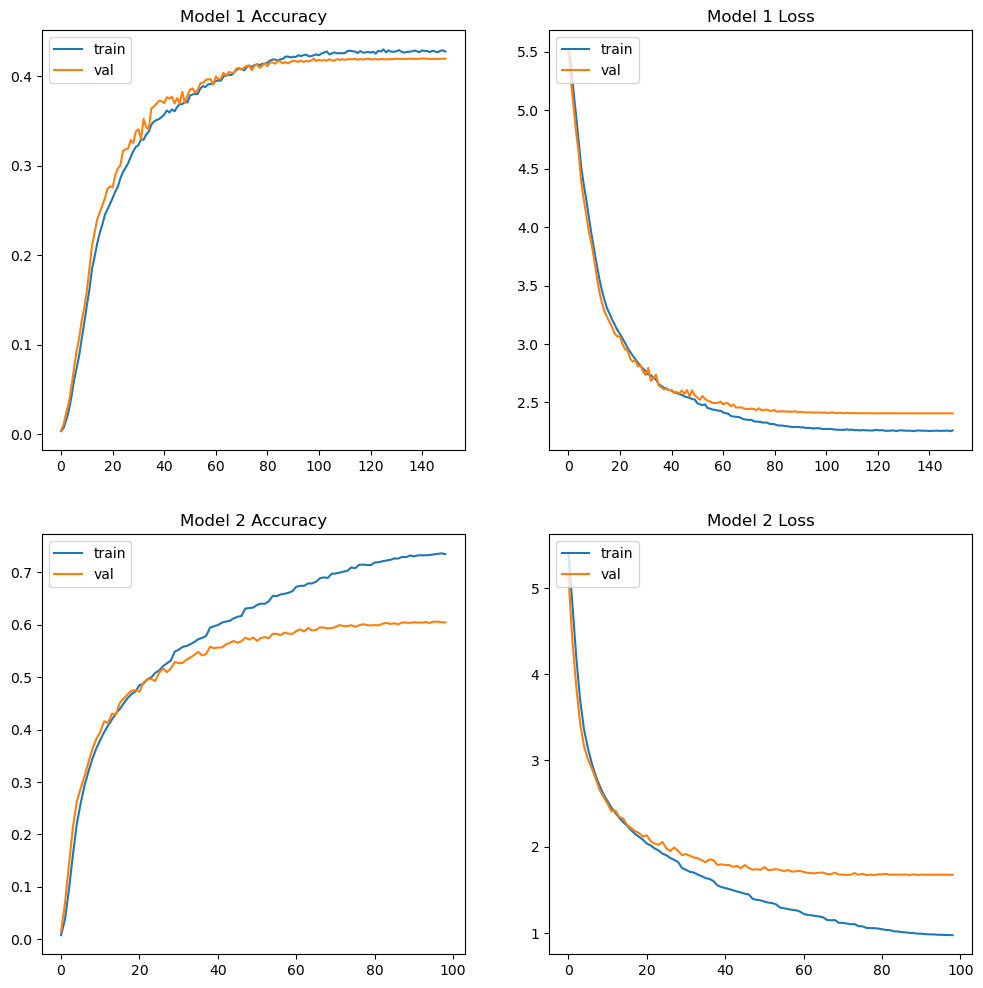

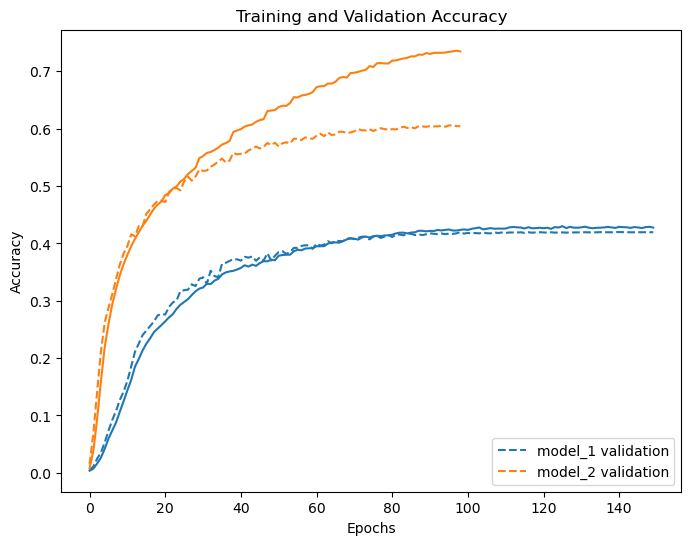

In [14]:
eval_class = Evaluate()
eval_class.plot_valdiation_multiple_models(model_histories)
eval_class.plot_validation_cumlative(model_histories)

# <font color='289C4E'> Create submission <font><a class='anchor' id='future_work'></a> [↑](#top)
    

In [15]:
# https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline
class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, face_idx_range=(0, 468), lh_idx_range=(468, 489), 
                 pose_idx_range=(489, 522), rh_idx_range=(522, 543)):
        super(PrepInputs, self).__init__()
        self.idx_ranges = [face_idx_range, lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [3*(_range[1]-_range[0]) for _range in self.idx_ranges]
    
    def call(self, x_in):
        
        # Split the single vector into 4
        xs = [x_in[:, _range[0]:_range[1], :] for _range in self.idx_ranges]
        
        # Reshape based on specific number of keypoints
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        # Drop empty rows - Empty rows are present in 
        #   --> pose, lh, rh
        #   --> so we don't have to for face
        xs[1:] = [
            tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0)
            for _x in xs[1:]
        ]
        
        # Get means and stds
        x_means = [tf.math.reduce_mean(_x, axis=0) for _x in xs]
        x_stds  = [tf.math.reduce_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return tf.expand_dims(x_out, axis=0)
    
PrepInputs()(model_class.utilties.load_relevant_data_subset(train_data.path[0]))

<tf.Tensor: shape=(1, 3258), dtype=float32, numpy=
array([[ 0.52765715,  0.37799075, -0.03728105, ...,  0.15039368,
         0.0695638 ,  0.04059875]], dtype=float32)>

In [16]:
# https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline
class TensorflowLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model):
        """
        Initializes the TensorflowLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TensorflowLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = PrepInputs()
        self.islr_model   = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.islr_model(inputs)[0, :]
        return {'outputs': outputs}

tflite_keras_model = TensorflowLiteModel(islr_model=model)
data_test = model_class.utilties.load_relevant_data_subset(train_data.path[0])
demo_output = tflite_keras_model(model_class.utilties.load_relevant_data_subset(train_data.path[0]))["outputs"]

# <font color='289C4E'> Validate submission <font><a class='anchor' id='future_work'></a> [↑](#top)


In [17]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/models/model.tflite

!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

# output = prediction_fn(inputs=model_class.utilties.load_relevant_data_subset(train_data.path[0]))
# sign = np.argmax(output["outputs"])

# print("prediction : ", eval_class.decoder(sign))
# print("ground truth : ", train_data.sign[0])

for path in train_data.path[1:10]:
    output = prediction_fn(inputs=model_class.utilties.load_relevant_data_subset(path))
    sign = np.argmax(output["outputs"])
    print('')
    print('otuput: ', output["outputs"])
    print("prediction : ", eval_class.decoder(sign))
    print("ground truth : ", train_data.sign[0])

	zip warning: name not matched: /kaggle/working/models/model.tflite

zip error: Nothing to do! (submission.zip)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.4 MB/s eta 0:00:00

otuput:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

In [18]:
submission_path = '/kaggle/working/model.tflite'
!zip submission.zip $submission_path

  adding: kaggle/working/model.tflite (deflated 7%)


# <font color='289C4E'>Future work <font><a class='anchor' id='future_work'></a> [↑](#top)
    
    
There is a lot more to do be done here in order to improve overall classification accuracy! some things that this notebook did not explore but would like to for future work:  
- data augmentation to create more data
- preprocessing data differently, handling NaN's differently
- adding LSTM's to see how that affects accuracy

# <font color='289C4E'>References <font><a class='anchor' id='references'></a> [↑](#top)
    
[🤟 GISLR 🤟 - 📚Learn – 🔭EDA – 🤖Baseline](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#background_information)
    
[Tips To Make Your Notebook Look Better]()
    
[Isolated Sign Language Aggregation Dataset](https://www.kaggle.com/datasets/lonnieqin/isolated-sign-language-aggregation-dataset?select=train.csv)